# Octopath Traveler Weakness Analysis

## Motivation

This project is an attempt from me to merge two of my favorite computer science topics - machine learning and data mining. I’ve been an avid dataminer for over 5 years outside of my academic career, and I figured “if I can get the raw data from some software, I can probably analyze it with what I’ve learned in this class.”

Aside from my personal motivation of applying what I’ve learned to my hobbies, I believe this is also important for understanding if there is some deterministic correlation between how an enemy is designed in Octopath Traveler, and how its weaknesses are assigned. In addition, by creating a sufficient decoder CNN for sprites, it’s also possible to generate new sprites by specifying the weakness confidence for the 12 weakness dimensions, or design an enemy sprite and automatically generate weaknesses. 

I concede that there is no value to being able to determine an enemy’s weakness in the game itself, because all weaknesses in the game are already able to be datamined. Unless the next iteration of Octopath Traveler procedurally generated new enemies with specific weaknesses - an event that will likely never happen - this CNN is impractical for improving gameplay. However, for future reference - by creating an autoencoder from the CNN that determines weaknesses, we can automate the process of generating enemy sprites.


## Code - Part 1: Representing data

Major segments of the code are split to two notebooks - One that cleans up the data, and the other that runs the CNN model. The reason there are two notebooks is because one is created in my default python 3.9 environment, and the other has directML installed for me to locally run training data on my GPU, which is from AMD, and not supported by default tensorflow.

I will censor the data mining process because it is irrelevant to machine learning and can be excessively lengthy, but those interested could check out a tutorial I made over two years ago. 

https://www.youtube.com/watch?v=_EhwNMKmqHA

The ‘sprites’ I will be using are enemy icons, for two major reasons - firstly, all icons are 128x128x4 (RGB + Alpha channel), whereas not all sprites are of definitive size. If I were to use the animated sprite sheet, I would have over 10 times as much images, but I would have to add a lot of padding to non-boss enemies, since boss enemies in this game are given much larger sprites. This may lead to overfitting, since the CNN then wouldn’t generalize normal enemies and boss enemies, with the latter having access to thrice as much image space.


I will take EnemyDB, join it with the CharacterResourceDB table, and associate each enemy's weakness with a set of weaknesses and a sprite.

In [1]:
import pandas as pd
import sklearn
import numpy as np
import sys
import os
import json
import re

In [2]:
enemyDB = json.load(open('EnemyDB.json'))[0]
resourceDB = json.load(open('CharacterResourceDB.json'))[0]
textDB = json.load(open('GameTextEN.json', encoding="utf8"))[0]

del enemyDB['export_type']
del resourceDB['export_type']
del textDB['export_type']

In [3]:
enemydf = pd.DataFrame.from_dict(enemyDB).transpose()
resourcedf = pd.DataFrame.from_dict(resourceDB).transpose()
textdf = pd.DataFrame.from_dict(textDB).transpose()

In [4]:
cols = enemydf.columns

Literally all these columns, except for the enemy name, asset path, and weakness should be dropped.

In [5]:
enemydf = enemydf.drop(cols.drop(['DisplayNameID_151_570F1B1240B0BB42C31AA7A4F6CFAF72','ResourceLabel_295_2D43957442A6F48343BB639C79635FAE','AttributeResist_282_87881AFB4F4DD148EA692D8F63B73E16','WeaponResist_283_0BB9356646F9B928F5FC1584A458ABBC']), axis=1)

Now we remove all names that are null

In [6]:
enemydf = enemydf.mask(enemydf.eq('None')).dropna()

Now we one-hot encode.

Attributes go: Fire, Ice, Lightning, Wind, Light, Dark.

Weapons go: Sword, Spear, Dagger, Axe, Bow, Staff.

In [7]:
enemydf.index.name = 'Enemy_ID'
enemydf.head()

,DisplayNameID_151_570F1B1240B0BB42C31AA7A4F6CFAF72,ResourceLabel_295_2D43957442A6F48343BB639C79635FAE,AttributeResist_282_87881AFB4F4DD148EA692D8F63B73E16,WeaponResist_283_0BB9356646F9B928F5FC1584A458ABBC
Enemy_ID,,,,
ENE_BOS_WAR_C01_010,ENN_BOS_WAR_C01_010,ENE_BOS_WAR_C01_010,"[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::...","[EATTRIBUTE_RESIST::eWEAK, EATTRIBUTE_RESIST::..."
ENE_BOS_WAR_C01_020,ENN_BOS_WAR_C01_020,ENE_BOS_WAR_C01_020,"[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::...","[EATTRIBUTE_RESIST::eWEAK, EATTRIBUTE_RESIST::..."
ENE_BOS_WAR_C02_010,ENN_BOS_WAR_C02_010,ENE_BOS_WAR_C02_010,"[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::...","[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::..."
ENE_BOS_WAR_C02_020,ENN_BOS_WAR_C02_020,ENE_BOS_WAR_C02_020,"[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::...","[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::..."
ENE_BOS_WAR_C04_010,ENN_BOS_WAR_C04_010,ENE_BOS_WAR_C04_010,"[EATTRIBUTE_RESIST::eNONE, EATTRIBUTE_RESIST::...","[EATTRIBUTE_RESIST::eWEAK, EATTRIBUTE_RESIST::..."


In [8]:
enemydf[['Magic', 'Fire','Ice','Lightning','Wind','Light','Dark']] = pd.DataFrame(enemydf['AttributeResist_282_87881AFB4F4DD148EA692D8F63B73E16'].tolist(), index=enemydf.index)
enemydf[['Sword', 'Spear', 'Dagger', 'Axe', 'Bow', 'Staff','Physical']] = pd.DataFrame(enemydf['WeaponResist_283_0BB9356646F9B928F5FC1584A458ABBC'].tolist(), index=enemydf.index)

enemydf = enemydf.drop(['AttributeResist_282_87881AFB4F4DD148EA692D8F63B73E16',	'WeaponResist_283_0BB9356646F9B928F5FC1584A458ABBC','Magic','Physical'],axis=1)
enemydf = enemydf.rename({'DisplayNameID_151_570F1B1240B0BB42C31AA7A4F6CFAF72':'DisplayName','ResourceLabel_295_2D43957442A6F48343BB639C79635FAE':'ResourceLabel'},axis=1)

In [9]:
def find_if_possible(name):
    try:
        return textdf.loc[name]['Text']['string']
    except:
        return 'None'

enemydf['DisplayName'] = enemydf['DisplayName'].apply(find_if_possible)
enemydf = enemydf.drop(enemydf[enemydf['DisplayName'].str.contains('None')].index)

In [10]:
mapping = {"EATTRIBUTE_RESIST::eWEAK":1,"EATTRIBUTE_RESIST::eNONE":0}
enemydf = enemydf.replace(mapping)

In [11]:
enemydf = enemydf.reset_index()
enemydf.head()

,Enemy_ID,DisplayName,ResourceLabel,Fire,Ice,Lightning,Wind,Light,Dark,Sword,Spear,Dagger,Axe,Bow,Staff
0,ENE_BOS_WAR_C01_010,Ritsu Mishuyo,ENE_BOS_WAR_C01_010,1,0,0,0,0,0,1,0,0,0,1,0
1,ENE_BOS_WAR_C01_020,Ritsu's Footman,ENE_BOS_WAR_C01_020,1,0,0,0,0,0,1,1,0,0,1,0
2,ENE_BOS_WAR_C02_010,Bandelam the Reaper,ENE_BOS_WAR_C02_010,1,0,0,0,1,0,0,1,1,1,0,0
3,ENE_BOS_WAR_C02_020,Borneau,ENE_BOS_WAR_C02_020,0,0,0,0,0,0,0,0,0,0,0,0
4,ENE_BOS_WAR_C04_010,Rai Mei,ENE_BOS_WAR_C04_010,1,0,0,0,1,0,1,0,0,0,0,1


Now to combine with resourcedb

In [12]:
def find_if_possible(name):
    try:
        return resourcedf.loc[name]['ActionOrderIconL']['asset_path_name']
    except:
        return 'None'

enemydf['asset_path'] = enemydf['ResourceLabel'].apply(find_if_possible)
enemydf = enemydf.drop(enemydf[enemydf['asset_path'] == 'None'].index)
enemydf = enemydf.drop('ResourceLabel',axis=1)

In [13]:
enemydf['asset_path'] = enemydf['asset_path'].apply(lambda x: ".\\enemyicons\\" + (x[57:])[:int(len(x[57:])/2)] + '.png')
# edge case:
enemydf = enemydf.drop(enemydf[enemydf['asset_path']=='.\\enemyicons\\UiTX_Battle_Oder_Select_Ritsu.png'].index)
enemydf.reset_index(drop=True, inplace=True)

In [14]:
enemydf.to_csv('dataset.csv')

I imported the enemy data, character resource, and game text json files, removed unnecessary parameters, and joined the lists in an appropriate manner. I am left with over 700 valid enemies with sprites and weaknesses. I then exported the data frame into a CSV so I may run analysis on the code with tools (tensorflow/scikit learn).


Below is a sample CNN that will later be improved upon when I am given access to a GPU.

## Part 2: CNN creation

In [1]:
import pandas as pd
import sklearn
import numpy as np
import sys
import os
import json
import re
from PIL import Image

import tensorflow as tf
import keras

df = pd.read_csv('dataset.csv')

In [4]:
import tensorflow as tf
print(tf.__version__)

print(tf.config.list_physical_devices())

2.12.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Confirming all images are of the same size

In [8]:
size = (0,0)
for i in df['asset_path']:
    if os.path.exists(i):
        if Image.open(i).size != size:
            print(Image.open(i).size)
            size = Image.open(i).size
    else:
        print(i)

(128, 128)


In [9]:
tf.test.is_built_with_cuda()

False

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [11]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

I have a AMD GPU so I can't do much about this ):

Importing VGG16, I could set all but the last 4 layers to be untrainable, flatten the last layer, and have the final layer be assigned to each of the 12 weaknesses. I’ve later learned that this is NOT ideal, for reasons I will explain here:


In [29]:
import keras.utils as image

def arrange_data(dfin):
    
    image_data = []
    img_paths = np.asarray(dfin['asset_path'])
    
    for i in range(len(img_paths)):
        img = image.load_img(img_paths[i],target_size=(128, 128, 3))
        img = image.img_to_array(img)
        img = img/255
        image_data.append(img)
        
        
    X = np.array(image_data)
    Y = np.array(dfin[['Fire','Ice','Lightning','Wind','Light','Dark','Sword','Spear','Dagger','Axe','Bow','Staff']])
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)



x_train, y_train = arrange_data(dfin = train)


x_test, y_test = arrange_data(dfin = test)

Shape of images: (640, 128, 128, 3)
Shape of labels: (640, 12)
Shape of images: (72, 128, 128, 3)
Shape of labels: (72, 12)


In [31]:
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freeze up to last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False


model = models.Sequential()

model.add(vgg_conv)

num_classes = 12

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS=50
BS = 64

# data augmentation to reduce overfit
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)

model.save('Model_4d.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              8389632   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 12)                12300     
                                                                 
Total params: 23,116,620
Trainable params: 15,481,356
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50


C:\Users\Alex Dai\AppData\Local\Temp\ipykernel_14072\4022961056.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)


10/10 [==============================] - 19s 2s/step - loss: 0.6655 - accuracy: 0.0375 - val_loss: 0.6111 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 0.6273 - accuracy: 0.0391 - val_loss: 0.6046 - val_accuracy: 0.0417
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 0.6174 - accuracy: 0.0578 - val_loss: 0.6028 - val_accuracy: 0.0278
Epoch 4/50
10/10 [==============================] - 20s 2s/step - loss: 0.6123 - accuracy: 0.0531 - val_loss: 0.5992 - val_accuracy: 0.0833
Epoch 5/50
10/10 [==============================] - 20s 2s/step - loss: 0.6072 - accuracy: 0.0500 - val_loss: 0.5917 - val_accuracy: 0.0278
Epoch 6/50
10/10 [==============================] - 21s 2s/step - loss: 0.6016 - accuracy: 0.0484 - val_loss: 0.5923 - val_accuracy: 0.0556
Epoch 7/50
10/10 [==============================] - 21s 2s/step - loss: 0.5939 - accuracy: 0.0594 - val_loss: 0.5867 - val_accuracy: 0.0417
Epoch 8/50
10/10 [=========

I'll let this run to completion for the sake of presentation, but this ONLY uses the CPU (AKA non-CUDA) to train, which leads to absolutely terrible results.

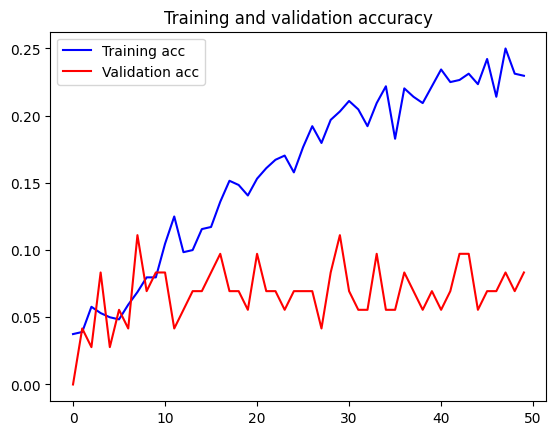

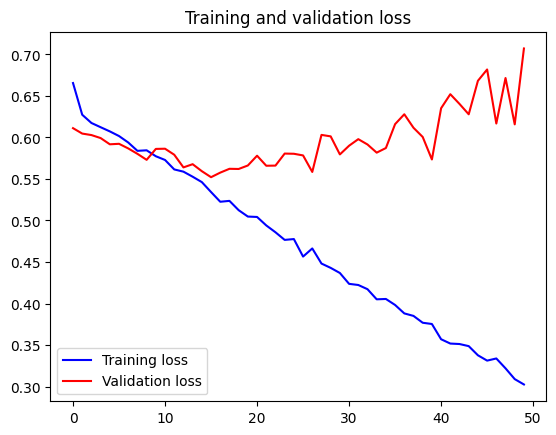

In [36]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As we can see, the CNN training didn't quite go as well as one would hope. I will later do this with a GPU to see how this compares.